In [51]:
import torch 
import random
import torchvision.models as models 
import os
import torch.nn.functional as F 
from PIL import Image
import torch
import torchvision.models as models
import pytorch_lightning as pl
from torchvision.models.resnet import ResNet18_Weights
import numpy as np 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix 
from torchvision import transforms 
from torchvision.datasets import ImageFolder 
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import ModelCheckpoint 
from pytorch_lightning.loggers import TensorBoardLogger 
from torchmetrics import Accuracy, F1Score, AUROC, Precision 


In [50]:
def set_seed(seed=10): 

    torch.manual_seed(seed) 

    np.random.seed(seed) 

    random.seed(seed) 

    os.environ['PYTHONHASHSEED'] = str(seed) 

    torch.backends.cudnn.deterministic = True 

    torch.backends.cudnn.benchmark = False 


In [52]:
# Define transformation used in test datasets 

def get_test_transformation(): 

    return transforms.Compose([ 

        transforms.Resize((224, 224)), 

        transforms.ToTensor(), 

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 

    ]) 

  

# Load test data 

def load_data(path): 

    dataset = ImageFolder(root=path, transform=get_test_transformation()) 

    return DataLoader(dataset, batch_size=32, shuffle=False) 

  

# Define the model class 

class LitModel(pl.LightningModule): 

    def __init__(self, base_model, num_classes=1): 

        super().__init__() 

        self.model = base_model(pretrained=True) 

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes) 

     

    def forward(self, x): 

        x = self.model(x) 

        return x 


In [53]:
def evaluate_model(model, loader):
    model.eval()
    model.cuda()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)
            preds = torch.sigmoid(outputs).squeeze()
            # Ensure preds are always iterable (1D)
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            preds = preds.round().cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, f1, auc, cm


In [54]:
def plot_confusion_matrix(cm, title): 

    plt.figure(figsize=(5, 5)) 

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) 

    plt.title(title) 

    plt.colorbar() 

    tick_marks = np.arange(2) 

    plt.xticks(tick_marks, ["Dog", "Cat"], rotation=45) 

    plt.yticks(tick_marks, ["Dog", "Cat"]) 

    plt.tight_layout() 

    plt.ylabel('True label') 

    plt.xlabel('Predicted label') 

    plt.show() 

In [55]:
class AnimalImage(Dataset):
    def __init__(self, data_root, transformation, mode="train"):
        self.data_root = data_root
        self.transformation = transformation
        self.list_imgs = [f for f in os.listdir(data_root) if f.endswith('.jpg')]
        self.mode = mode

    def __len__(self):
        return len(self.list_imgs)

    def __getitem__(self, idx):
        img_name = self.list_imgs[idx]
        img_path = os.path.join(self.data_root, img_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transformation(img)
        label = 1 if "cat" in img_name else 0
        return img, label


In [56]:
class LitModel(pl.LightningModule):
    def __init__(self, base_model, num_classes=1):
        super().__init__()
        self.model = base_model(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(self.model.fc.in_features, 1000),
            torch.nn.Linear(1000, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [57]:
# Assuming the model checkpoint paths are correct and they match the expected architecture
model_a = LitModel.load_from_checkpoint(
    checkpoint_path='./checkpoints/Model_A/resnet18-epoch=16-val_loss=0.10.ckpt',
    base_model=models.resnet18,
    num_classes=1
)

model_b = LitModel.load_from_checkpoint(
    checkpoint_path='./checkpoints/Model_B/resnet18-epoch=9-val_loss=0.32.ckpt',
    base_model=models.resnet18,
    num_classes=1
)


Model A - Accuracy: 0.98, F1 Score: 0.98, AUC: 0.98
Model B - Accuracy: 0.79, F1 Score: 0.82, AUC: 0.79


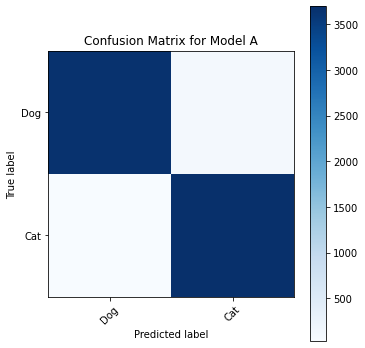

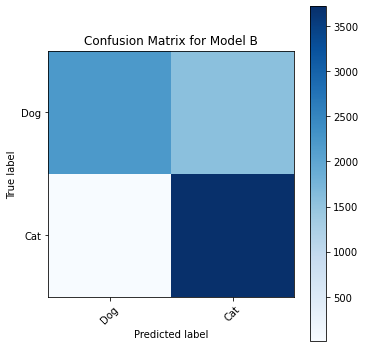

In [58]:
# Set seed for reproducibility
set_seed(42)

# Load test data
data_root = "/home/mdnurualabsarsiddiky/Desktop/Absar/ECGR8119/Midterm_2024/dogs_vs_cats/train"
transformation = get_test_transformation()
dataset = AnimalImage(data_root, transformation, mode="test")
test_size = int(0.3 * len(dataset))
train_size = len(dataset) - test_size
_, test_data = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Evaluate both models
accuracy_a, f1_a, auc_a, cm_a = evaluate_model(model_a, test_loader)
accuracy_b, f1_b, auc_b, cm_b = evaluate_model(model_b, test_loader)

# Display results
print("Model A - Accuracy: {:.2f}, F1 Score: {:.2f}, AUC: {:.2f}".format(accuracy_a, f1_a, auc_a))
print("Model B - Accuracy: {:.2f}, F1 Score: {:.2f}, AUC: {:.2f}".format(accuracy_b, f1_b, auc_b))

# Plot confusion matrices
plot_confusion_matrix(cm_a, 'Confusion Matrix for Model A')
plot_confusion_matrix(cm_b, 'Confusion Matrix for Model B')
